In [ ]:
from datasets import load_from_disk

# Load the dataset which is already downloaded
ds = load_from_disk("wildchat_local")
train_ds = ds["train"]

train_ds

Dataset({
    features: ['conversation_hash', 'model', 'timestamp', 'conversation', 'turn', 'language', 'openai_moderation', 'detoxify_moderation', 'toxic', 'redacted', 'state', 'country', 'hashed_ip', 'header'],
    num_rows: 837989
})

**Research Question 1 :**

**Can we predict if a conversation is for 'Technical/Coding' help versus 'General/Creative' help based on the first user prompt?**

In [ ]:
# Extracting first user prompt from each conversation
def extract_first_user_prompt(example):
    for turn in example["conversation"]:
        if turn["role"] == "user":
            return {
                "conversation_hash": example["conversation_hash"],
                "prompt": turn["content"]
            }
    return {
        "conversation_hash": example["conversation_hash"],
        "prompt": ""
    }

prompts_ds = train_ds.map(extract_first_user_prompt)

In [ ]:
# Removing all columns except conversation_hash and prompt
prompts_ds = prompts_ds.remove_columns(
    [col for col in prompts_ds.column_names if col not in ["conversation_hash", "prompt"]]
)

prompts_ds

Dataset({
    features: ['conversation_hash', 'prompt'],
    num_rows: 837989
})

In [ ]:
# Sample 1500 prompts for labeling
labeling_sample = prompts_ds.shuffle(seed=42).select(range(1500))

In [ ]:
# Load the labeling sample
import pandas as pd

labeling_df = labeling_sample.to_pandas()
labeling_df.head()

,conversation_hash,prompt
0,3bac6530e8ae0340833ace0871f67fe3,\n As a prompt gene...
1,aceb43170c4f4903360888141409916d,[there would be dialogue in this story:]\n\n(E...
2,0cee675ca3dc17974e8f3afaa08d3fb0,You are a Turk. From now on you will answer on...
3,41b529aecbd130a5520308d6379d9d58,Полимерия
4,cdc554d27027c976ac937f0fdd7f0622,


In [ ]:
labeling_df["label"] = ""

labeling_df.to_csv("rq1_prompt_labels.csv", index=False)

**In this step, I implemented Data Cleaning through another supplementary python file and also Manually cleaned datasets by assigning labels to the data.**

In [ ]:
# Load and filter labeled data
import pandas as pd

labels_df = pd.read_csv("rq1_final_prompts_labels.csv")

# Drop unlabeled rows (during annotation phase)
labels_df = labels_df[labels_df["label"] != ""]

In [ ]:
# Create label mapping
label_map = {"Technical": 1, "General": 0}
labels_df["label_id"] = labels_df["label"].map(label_map)

In [ ]:
# Clean the prompt column
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    return text.strip()

labels_df["clean_prompt"] = labels_df["prompt"].apply(clean_text)

In [ ]:
labels_df 

,conversation_hash,prompt,label,label_id,clean_prompt
0,3bac6530e8ae0340833ace0871f67fe3,As a prompt generator for a generative AI call...,General,0,as a prompt generator for a generative ai call...
1,aceb43170c4f4903360888141409916d,[there would be dialogue in this story:]\n\n(E...,General,0,[there would be dialogue in this story:] (ever...
2,0cee675ca3dc17974e8f3afaa08d3fb0,You are a Turk. From now on you will answer on...,General,0,you are a turk. from now on you will answer on...
3,41b529aecbd130a5520308d6379d9d58,Полимерия,General,0,полимерия
4,1c8fadfc88a6b18e5ae82bc6d29aa2a3,Qtransform实现镜像,General,0,qtransform实现镜像
...,...,...,...,...,...
2481,9fb2918959550f19334e415652c2e8b0,"<?php \n$connection_link = new mysqli(""localho...",Technical,1,"<?php $connection_link = new mysqli(""localhost..."
2482,6b569b277c85a1a78cd94cd850703bee,"检查下面的英文语法To solve this problem, this paper is ...",Technical,1,"检查下面的英文语法to solve this problem, this paper is ..."
2483,057df01d711ad60b23fdac5d48e98f74,convert this python code into javascript. I wa...,Technical,1,convert this python code into javascript. i wa...
2484,654c64b9c5a50ea64708e1b47cb7df30,"write an article comparing SQS, SNS, Kinesis, ...",Technical,1,"write an article comparing sqs, sns, kinesis, ..."


In [ ]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    labels_df["clean_prompt"],
    labels_df["label_id"],
    test_size=0.2,
    random_state=42,
    stratify=labels_df["label_id"]
)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define models
model_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("clf", LogisticRegression(max_iter=1000))
])

model_svm = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("clf", LinearSVC())
])

# Train models
model_lr.fit(X_train, y_train)
model_svm.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=20000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf', LinearSVC())])

In [16]:
print("====== Logistic Regression ======")

# Predictions
y_train_pred_lr = model_lr.predict(X_train)
y_test_pred_lr = model_lr.predict(X_test)

# Accuracy
print("Training Accuracy:", accuracy_score(y_train, y_train_pred_lr))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_lr))

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred_lr, target_names=["General","Technical"]))

print("====== Linear SVM ======")

# Predictions
y_train_pred_svm = model_svm.predict(X_train)
y_test_pred_svm = model_svm.predict(X_test)

# Accuracy
print("Training Accuracy:", accuracy_score(y_train, y_train_pred_svm))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_svm))

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred_svm, target_names=["General","Technical"]))

====== Logistic Regression ======
Training Accuracy: 0.9421529175050302
Test Accuracy: 0.8875502008032129

Classification Report:

              precision    recall  f1-score   support

     General       0.86      0.96      0.91       282
   Technical       0.93      0.80      0.86       216

    accuracy                           0.89       498
   macro avg       0.90      0.88      0.88       498
weighted avg       0.89      0.89      0.89       498

====== Linear SVM ======
Training Accuracy: 0.9899396378269618
Test Accuracy: 0.9036144578313253

Classification Report:

              precision    recall  f1-score   support

     General       0.89      0.95      0.92       282
   Technical       0.93      0.84      0.88       216

    accuracy                           0.90       498
   macro avg       0.91      0.90      0.90       498
weighted avg       0.91      0.90      0.90       498



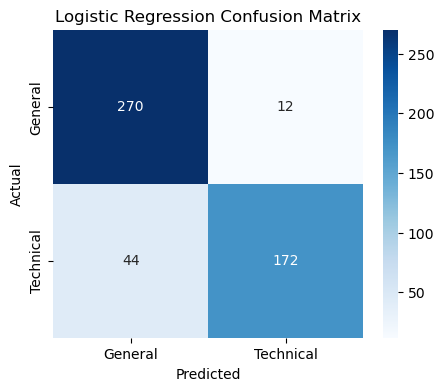

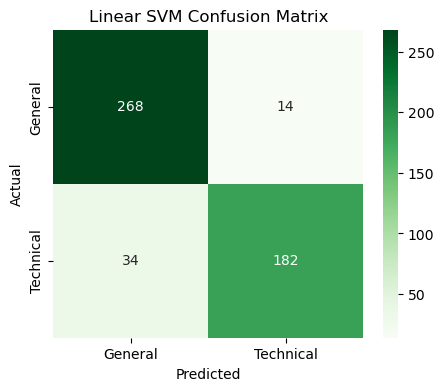

In [ ]:
# Create confusion matrices for both models
cm_lr = confusion_matrix(y_test, y_test_pred_lr)

plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=["General","Technical"],
            yticklabels=["General","Technical"])
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

cm_svm = confusion_matrix(y_test, y_test_pred_svm)

plt.figure(figsize=(5,4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["General","Technical"],
            yticklabels=["General","Technical"])
plt.title("Linear SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# ModelComparison Table
results = {
    "Model": ["Logistic Regression", "Linear SVM"],
    "Train Accuracy": [
        accuracy_score(y_train, y_train_pred_lr),
        accuracy_score(y_train, y_train_pred_svm)
    ],
    "Test Accuracy": [
        accuracy_score(y_test, y_test_pred_lr),
        accuracy_score(y_test, y_test_pred_svm)
    ]
}

import pandas as pd
comparison_df = pd.DataFrame(results)
comparison_df

,Model,Train Accuracy,Test Accuracy
0,Logistic Regression,0.942153,0.887550
1,Linear SVM,0.989940,0.903614


In [ ]:
import pandas as pd

# Create a DataFrame with results
results_df = pd.DataFrame({
    "text": X_test,
    "true_label": y_test,
    "predicted_label": y_pred
})

# False Positives (Predicted Technical but actually General)
false_positives = results_df[
    (results_df["true_label"] == 0) &
    (results_df["predicted_label"] == 1)
]

print("\n===== False Positives (General → Technical) =====")
print(false_positives.head(5)["text"].values)


# False Negatives (Predicted General but actually Technical)
false_negatives = results_df[
    (results_df["true_label"] == 1) &
    (results_df["predicted_label"] == 0)
]

print("\n===== False Negatives (Technical → General) =====")
print(false_negatives.head(5)["text"].values)


===== False Positives (General → Technical) =====
["you will need to help me fill out some data on various military tech. when prompted, i will provide you a short name of the military unit i need researched, alongside a single link. your task will be to use these sources to fill out data exactly like the following format i'll provide below. if you cannot find solid information on specific unit value (such as it's speed or move range) you must use your own judgement and estimate/guess the value, do not leave it blank. as long as the values sound about right, it should be fine. responses should look exactly like the template i provide below, but you may include a short explanation or misc text in the response unless specified that a field can be left blank, you must guess/estimate every other value based off your own judgement and research on similar units. here is the following format i will need you to output your answers in: name: _____ year produced: _____ weight: _____ crew: _____

**Research Question 2: The "Power User" Profile: Analyzing Prompt Complexity**

**Is there a correlation between the length of a user’s prompt and the perceived quality of the AI's response?**

In [26]:
pip install textstat

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
from datasets import load_from_disk
import textstat # Library for readability scores

# 1. Load the multi-file Arrow dataset from your local folder
ds = load_from_disk("wildchat_local")
train_ds = ds["train"]

# 2. Extract pairs and Preprocess (English-only, first turn)
def extract_complexity_data(example):

    if example['language'] == 'English' and len(example['conversation']) >= 2:
        user_prompt = example['conversation'][0]['content']
        ai_response = example['conversation'][1]['content']
        return {
            'prompt_text': user_prompt,
            'response_text': ai_response,
            'prompt_len': len(user_prompt.split()), # Prompt Complexity Metric
            'response_len': len(ai_response.split()),# Basic Quality Metric
            'valid' : True
        }
    return {
        'prompt_text': "", 
        'response_text': "", 
        'prompt_len': 0, 
        'response_len': 0,
        'valid': False
    }

# Map the extraction across the dataset
processed_ds = train_ds.map(extract_complexity_data).filter(lambda x: x is not None)

In [28]:
def label_quality(example):
    # Calculate Readability (higher score often means better structure)
    quality_score = textstat.flesch_reading_ease(example['response_text'])
    
    # Define a 'High Quality' binary label (Example: Long response + clear readability)
    is_high_quality = 1 if (example['response_len'] > 100 and quality_score > 60) else 0
    
    return {'quality_score': quality_score, 'is_high_quality': is_high_quality}

labeled_ds = processed_ds.map(label_quality)

# Convert to Pandas for correlation analysis
df = labeled_ds.to_pandas()

In [29]:
# 1. First, remove rows where prompt_len is 0 (cleaning the noise)
df_cleaned = df[df['prompt_len'] > 0]

# 2. Separate the 'High Quality' and 'Standard Quality' rows
high_quality = df_cleaned[df_cleaned['is_high_quality'] == 1]
standard_quality = df_cleaned[df_cleaned['is_high_quality'] == 0]

# 3. Determine how many samples we can take
# We want to match the smaller group (High Quality) to keep it equal
n_samples = min(len(high_quality), 1500) 

# 4. Sample equal amounts from both
high_quality_sample = high_quality.sample(n=n_samples, random_state=42)
standard_quality_sample = standard_quality.sample(n=n_samples, random_state=42)

# 5. Combine them into your final 3000-row (or less, if 1s are rare) file
supplemental_balanced = pd.concat([high_quality_sample, standard_quality_sample])

# 6. Shuffle the final list so the 1s and 0s are mixed up
supplemental_balanced = supplemental_balanced.sample(frac=1, random_state=42)

# 7. Save to CSV
final_columns = [
    'prompt_text', 'prompt_len', 
    'response_text', 'response_len', 
    'quality_score', 'is_high_quality'
]
supplemental_balanced[final_columns].to_csv("rq2_labels_rows.csv", index=False)

print(f"File created with {len(supplemental_balanced)} total rows.")
print(f"High Quality (1): {len(high_quality_sample)} rows")
print(f"Standard Quality (0): {len(standard_quality_sample)} rows")

File created with 3000 total rows.
High Quality (1): 1500 rows
Standard Quality (0): 1500 rows


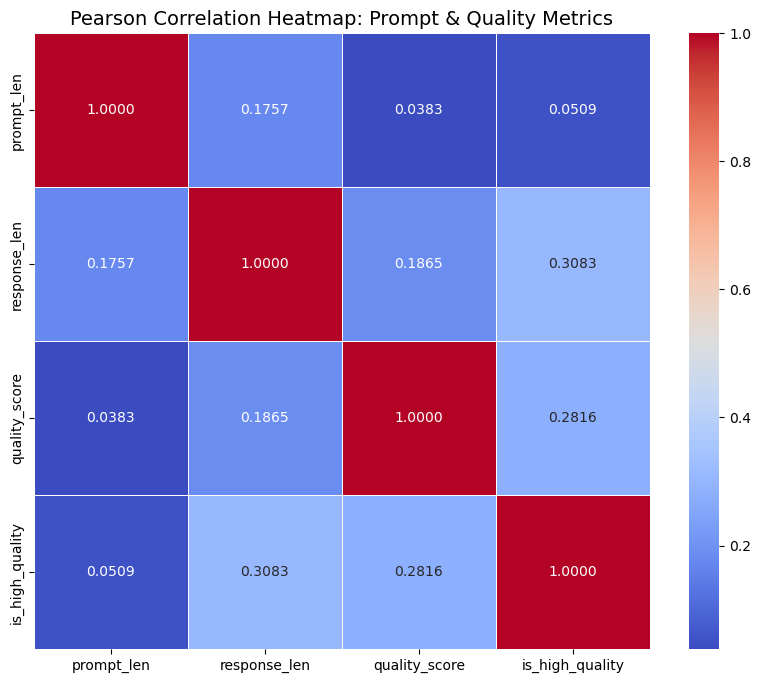

Pearson Correlation: 0.0383
P-value: 6.41932424137916e-270


In [30]:
from scipy.stats import pearsonr

corr_value, p_value = pearsonr(df["prompt_len"], df["quality_score"])

# 1. Select variables for the correlation matrix
corr_columns = ['prompt_len', 'response_len', 'quality_score', 'is_high_quality']
corr_matrix = df[corr_columns].corr(method='pearson')

# 2. Generate the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True,      # Show the correlation values in the boxes
            cmap='coolwarm', # Red for positive, Blue for negative
            fmt=".4f",       # Use 4 decimal places
            linewidths=0.5, 
            square=True)

plt.title('Pearson Correlation Heatmap: Prompt & Quality Metrics', fontsize=14)
plt.show()

print("Pearson Correlation:", round(corr_value, 4))
print("P-value:", p_value)

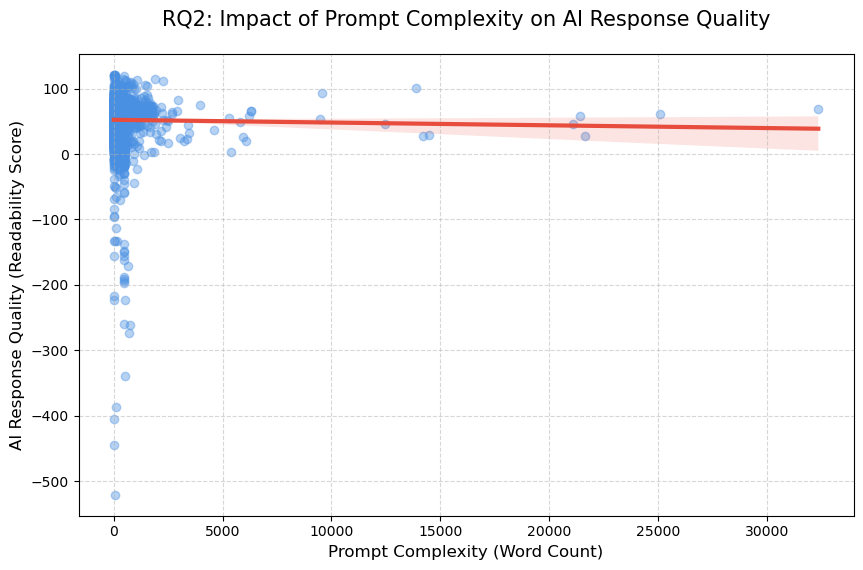

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load your balanced dataset
df_plot = pd.read_csv('rq2_labels_rows.csv')

# 2. Preprocessing: Remove rows where prompt_len is 0
df_plot = df_plot[df_plot['prompt_len'] > 0]

# 3. Create the Scatter Plot
plt.figure(figsize=(10, 6))

# sns.regplot creates the scatter dots AND the regression line automatically
sns.regplot(data=df_plot, 
            x='prompt_len', 
            y='quality_score', 
            scatter_kws={'alpha':0.4, 'color':'#4a90e2'}, # Blue dots with transparency
            line_kws={'color':'#e74c3c', 'lw':3})        # Solid red regression line

# 4. Professional Formatting
plt.title('RQ2: Impact of Prompt Complexity on AI Response Quality', fontsize=15, pad=20)
plt.xlabel('Prompt Complexity (Word Count)', fontsize=12)
plt.ylabel('AI Response Quality (Readability Score)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# 5. Save and Show
plt.savefig('rq2_final_scatter_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse

# 1. Load Data
df = pd.read_csv('rq2_labels_rows.csv')
df = df[df['prompt_len'] > 0].reset_index(drop=True)

# 2. Feature Engineering (Mixing Text and Length)
# This gives the model enough "signal" to actually predict Class 1
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
X_text = tfidf.fit_transform(df['prompt_text'])
X_numeric = scipy.sparse.csr_matrix(df[['prompt_len']].values)

# Combine text features and numeric length
X = scipy.sparse.hstack([X_text, X_numeric])
y = df['is_high_quality']

# 3. Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(solver='liblinear', random_state=42)

# 4. Cross Validation
cv_scores = cross_val_score(model, X, y, cv=5)
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

# 5. Final Results
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\n--- Final Classification Report ---")
print(classification_report(y_test, y_pred))

Mean CV Accuracy: 0.7813

--- Final Classification Report ---
              precision    recall  f1-score   support

           0       0.68      0.84      0.75       272
           1       0.84      0.67      0.75       328

    accuracy                           0.75       600
   macro avg       0.76      0.76      0.75       600
weighted avg       0.77      0.75      0.75       600



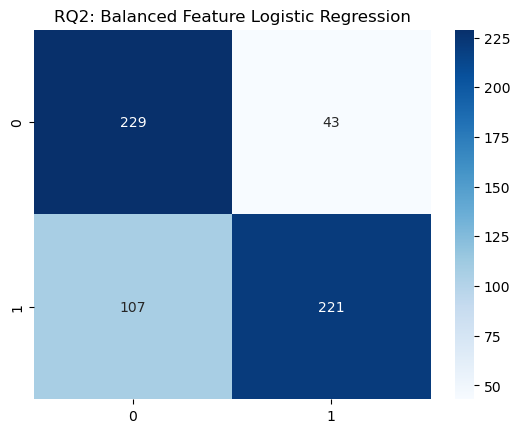

In [ ]:
# confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('RQ2: Balanced Feature Logistic Regression')
plt.show()

/var/folders/lt/5kvscd757td6m9_bypzzf4zh0000gn/T/ipykernel_86869/556625994.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Weight', y='Feature',


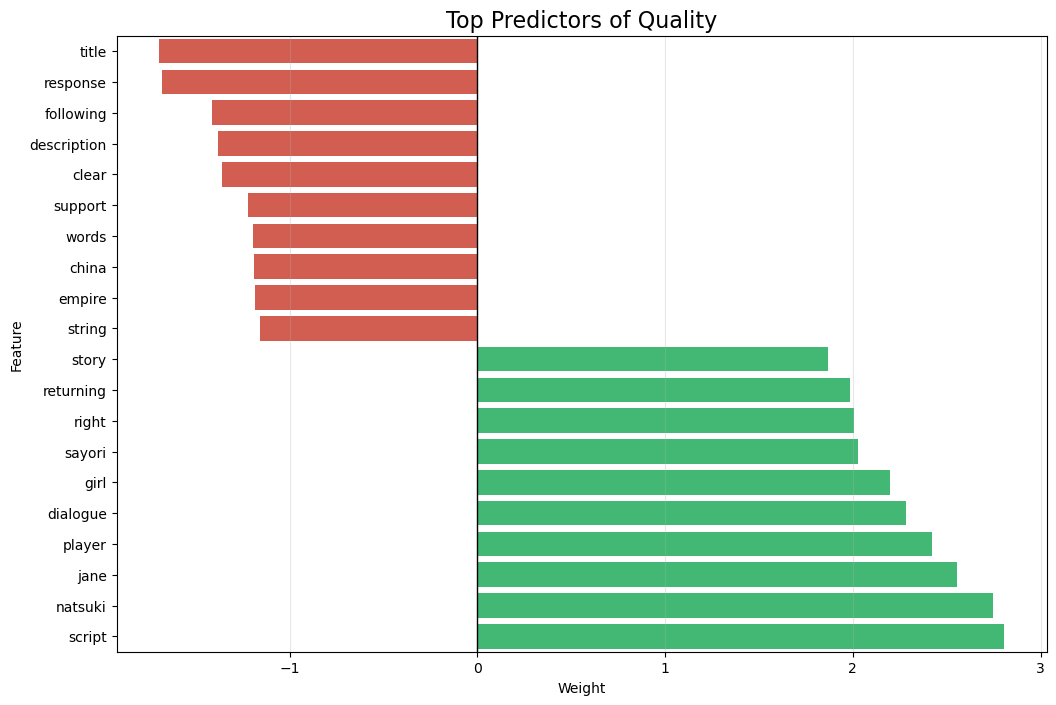

In [35]:
# the Logistic Regression model mathematically proving it through a process called Coefficient Weighting.
# 1. Feature Engineering
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
X_text = tfidf.fit_transform(df['prompt_text'])
X_numeric = scipy.sparse.csr_matrix(df[['prompt_len']].values)
X = scipy.sparse.hstack([X_text, X_numeric])
y = df['is_high_quality']
feature_names = tfidf.get_feature_names_out().tolist() + ['prompt_len']

# 2. Train and Extract Weights
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X, y)
importance_df = pd.DataFrame({'Feature': feature_names, 'Weight': model.coef_[0]})

# 3. Filter for Top 10 Positive and Top 10 Negative Features
top_features = pd.concat([importance_df.sort_values(by='Weight').head(10), 
                          importance_df.sort_values(by='Weight').tail(10)])

# 4. Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=top_features, x='Weight', y='Feature', 
            palette=['#e74c3c' if x < 0 else '#2ecc71' for x in top_features['Weight']])

plt.title('Top Predictors of Quality', fontsize=16)
plt.axvline(x=0, color='black', lw=1)
plt.grid(axis='x', alpha=0.3)
plt.show()